In [2]:
import numpy as np

import torch
from torch import nn

%matplotlib inline
from matplotlib import pyplot as plt

import cv2
import numpy as np
from pathlib import Path
from PIL import Image

In [8]:
n_epochs = 50
iter_per_epoch = 149
iters_done = np.linspace(iter_per_epoch, iter_per_epoch * n_epochs, n_epochs)

In [61]:
exp_03_31_19_00 = {
    'title': '3D MSESmoothLoss, lr=1e-5',
    'eval': np.float32([521, 489, 482, 468, 464, 462, 451, 431, 410, 394])
}

exp_03_31_20_12 = {
    'title': '2D MSELoss, lr=1e-5',
    'eval': np.float32([700.9966758367722, 748.2808344795965, 864.3234181568088, 758.5170220082531, 948.5730169646951, 693.3798716185236, 750.689477303989, 929.6364053186612, 967.8256533700138, 816.4927785419533])
}

exp_03_31_20_12 = {
    'title': '2D MSELoss, lr=1e-5',
    'eval': np.float32([700.9966758367722, 748.2808344795965, 864.3234181568088, 758.5170220082531, 948.5730169646951, 693.3798716185236, 750.689477303989, 929.6364053186612, 967.8256533700138, 816.4927785419533])
}

exp_06_17_53 = {
    'title': '2D MSELoss, lr=1e-7',
    'train': np.float32([1417.626893939394, 1428.6348905723905, 1384.1016414141413, 1414.1308922558921, 1411.2628367003367, 1560.111111111111, 1396.0992213804714, 1411.6637205387206, 1389.0784932659933, 1399.1584595959596, 1392.8040824915824, 1464.0223063973065, 1418.9170875420875, 1409.0128367003367, 1419.2274831649831, 2247.1736111111113, 1442.0064183501684, 1417.5638678451178, 2237.431818181818, 1893.4922138047139]),
    'eval': np.float32([791.7299403943146, 765.363709307657, 746.8823933975241, 713.126146263182, 709.3023842274187, 706.83035304906, 765.0421824850986, 732.1218477762494, 788.3492090784044, 812.9158069692802, 1226.671366345713, 750.0017193947731, 764.5414947271894, 1125.0193718477763, 930.6793901879871, 702.9150045850528, 864.239225126089, 779.0245873452544, 782.8419303071985, 894.836542870243])
}

exp_06_20_33 = {
    'title': '3D MSESmoothLoss, lr=1e-7',
    'train': np.float32([1493.3261784511785, 1447.7656776094277, 1387.421611952862, 1475.0252525252524, 1404.924031986532, 1488.700441919192, 1401.9119318181818, 1423.7446338383838, 1968.8943602693603, 1371.673085016835, 1454.4722222222222, 1587.225904882155, 1499.2900883838383, 1431.4377104377104, 1378.0335648148148, 1423.2078072390573, 1405.8280723905723, 1426.248106060606, 1404.8752104377104, 1648.75]),
    'eval': np.float32([677.9648097203118, 788.6662081613939, 772.1112448418157, 745.4347203117836, 1170.9115084823475, 721.8747707473636, 744.9497363594681, 771.8993007794589, 732.4604539202201, 705.9832072443833, 760.863709307657, 855.9672168729941, 760.4910591471802, 731.9348349381017, 762.8016964695094, 698.8861187528656, 746.1754928931683, 1036.5596056854654, 830.3117835855112, 835.2899472718937])
}

exp_06_22_35 = {
    'title': '',
    'train': np.float32([1856.0909090908, 1338.5801767676767, 1402.707702020202, 1343.1226851851852, 1350.1064814814815, 1346.6770833333333, 1378.069234006734, 1352.2045454545455, 1320.901936026936, 1376.0648148148148, 1483.5728114478115, 1318.3367003367002, 1505.2891414141413, 1353.189393939394, 1301.5378787878788, 1289.48547979798, 1325.9774831649831, 1326.4924242424242, 1296.9490740740741, 1280.4025673400674]),
    'eval': np.float32([698.428129298487, 754.5511233379184, 613.3396950939936, 759.5966872994039, 620.4483035304906, 990, 702.4779917469051, 562.3380330123797, 611.8607290233838, 575.6047684548372, 542.2577945896378, 572.0142136634571, 546.5386290692343, 472.09244612563043, 481.66271205868867, 931.8524759284732, 450.1439993122421, 444.03476043099494, 445.51192113709305, 428.8769199908299])
}

exp_07_17_52 = {
    'title': '',
    'train': np.float32([1568.669191919192, 1470.7022306397307, 1391.300505050505, 1386.4569654882155, 1381.8478535353536, 1467.7353745791245, 1403.2901936026935, 1401.3925715488215, 1453.7866161616162, 1387.7003367003367, 1407.3032407407406, 1438.4114057239058, 1381.0185185185185, 1396.8402777777778, 1377.015361952862, 1393.7146464646464, 1406.103324915825, 2272.128367003367, 1559.3800505050506, 1472.391308922559]),
    'eval': np.float32([802.3403255387437, 715.2917812929849, 676.0801237964237, 744.3944291609354, 719.5804676753783, 735.5301467216873, 990, 903.7193947730399, 813.6859238881248, 798.7925263640532, 726.4270403484641, 773.8522466758368, 745.6530834479596, 758.64030261348, 701.027739569005, 869.6190967446125, 685.9916322787712, 824.4058917927556, 970.8464007336084, 828.3285763411279])
}

exp_07_21_13 = {
    'title': '2D MSESmoothLoss, lr=2e-7',
    'train': np.float32([1456.8653198653199, 1385.125, 1404.3151304713804, 1383.1083754208755, 1407.5683922558921, 2307.281565656566, 1407.7253787878788, 1414.2401094276095, 1413.608164983165, 1470.5474537037037, 1425.517255892256, 1389.731691919192, 1404.229797979798, 1425.7457912457912, 1499.4037247474748, 1502.5666035353536, 1704.777882996633, 1497.2573653198654, 1642.7765151515152, 1420.6657196969697, 1509.3380681818182, 1393.4484427609427, 1546.1609848484848, 1569.440867003367, 1478.1687710437711, 1416.4501262626263, 1420.2796717171718, 1408.3425925925926, 1382.6054292929293, 1423.5892255892256, 1548.9157196969697, 1448.1853956228956, 1393.2744107744109, 1411.3194444444443, 1476.9585437710439, 1422.8238636363637, 1433.9863215488215, 1450.7093855218855, 1431.1196338383838, 1394.9993686868686, 1366.2954545454545, 1367.8027146464647, 1398.0844907407406, 1404.6198442760942, 1428.6353114478115, 1422.5582912457912, 1405.953388047138, 1410.5459806397307, 1456.9545454545455, 1400.9069865319866]),
    'eval': np.float32([740.32972260431, 798.4254928931683, 839.4193603851444, 798.1730284273269, 838.3302384227419, 935.8339637780834, 718.6287826685007, 989.3047913801008, 805.4201627693718, 690.9822902338377, 746.3941999082989, 743.0958276020174, 690.8414718019258, 737.0816712517194, 791.0609812012838, 845.0232691425952, 917.474552957359, 750.9635488308115, 857.9507106831728, 718.4813159101329, 862.4509399358093, 732.6440852819808, 727.0222375057314, 772.7971114167813, 697.7246102705182, 932.8029573590096, 806.5705524988538, 816.0183402109125, 1242.086542870243, 737.3911049977074, 765.5938789546079, 708.8313846859239, 6364223.853278313, 725.5827602017423, 732.588778083448, 766.0674002751032, 764.3892136634571, 839.6627120586887, 690.4023383768913, 1068.1378954607978, 834.1036221916552, 699.0244154057772, 714.034502521779, 958.3281178358551, 740.1405318661165, 699.3304676753783, 658.8287482806053, 720.7965382851903, 753.1285534158643, 781.8933975240715])
}

exp_07_21_22 = {
    'title': '2D MSESmoothLoss, lr=2e-7',
    'train': np.float32([1430.6017466329965, 1485.7574705387206, 1481.11047979798, 1402.33890993266, 1410.4353956228956, 1420.952861952862, 1418.6079545454545, 1369.7906144781145, 1453.1263678451178, 1376.5772306397307, 1386.378787878788, 1371.72117003367, 1367.9180345117845, 1422.266835016835, 1405.806712962963, 1393.0829124579125, 1781.790824915825, 1441.4693813131314, 1419.2422138047139, 1412.9304503367002]),
    'eval': np.float32([926.358035304906, 839.8065107748739, 769.1110729023384, 689.7815222375058, 990, 756.4500229252636, 692.4952430077946, 1194.1962402567628, 660.6423658872077, 661.2160132966529, 689.2208849151765, 628.7787712058689, 625.5459651535992, 608.2050664832645, 816.3496102705182, 670.4845254470426, 614.6666666666666, 623.5258482347547, 641.3332760201743, 632.706441999083])
}

exp_07_21_29 = {
    'title': '2D MSESmoothLoss, lr=1e-6',
    'train': np.float32([1550, 1384.696127946128, 1386.5686026936028, 1422.2352693602693, 1368.9246632996633, 1356.93265993266, 1436.2224326599326, 1460.3686868686868, 1409.7123316498316, 1417.4507575757575, 1443.232744107744, 1464.8323863636363, 1497.1688762626263, 1478.1907617845118, 1527.2819865319866, 1515.1536195286196, 1482.5313552188552, 1504.544191919192, 1582.7314814814815, 1558.2239057239058]),
    'eval': np.float32([1138.8245071068318, 647.0354195323246, 654.1948647409445, 642.0788629069234, 629.1553186611646, 621.3050206327373, 652.2152682255846, 630.9250343878955, 990, 1025.2410591471803, 876.286221916552, 992.576341127923, 1101.9798257679963, 817.3268569463548, 872.3300091701054, 767.7069005043558, 1654.98532783127, 975.6717102246675, 859.5422971114168, 856.1882164144888])
}

exp_04_08_08_32 = {
    'title': '2D MSESmoothLoss, lr=1e-7',
    'train': np.float32([1423.3419612794612, 2288.240740740741, 1377.6166877104376, 1415.042718855219, 1416.796085858586, 1383.1715067340067, 1423.1685606060605, 1431.078914141414, 1423.5998526936028, 1486.0590277777778, 1381, 1325, 1399, 1345, 1412, 1330, 1550, 1440, 1350, 1500]),
    'eval': np.float32([1190.1082072443833, 699.4817744154058, 705.3102934433746, 1103.6111875286, 990, 729.4911737734984, 698.2980284273269, 704.657611187528, 743.8639385602935, 694.6460339293902, 942, 856, 812, 768, 750, 812, 790, 820, 650, 690, 660])
}

In [68]:
exp_04_08_12_07 = {
    'title': '3D MSESmoothLoss, lr=1e-5',
    'train': np.float32([1389.843881302521, 1339.04556197479, 1412.9438025210084, 1337.8073792016808, 1354.6280199579833, 1327.0698529411766, 1372.9141281512605, 1313.2727153361345, 1239.0744485294117, 1307.406643907563, 1357.4206932773109, 1253.4921218487395, 1306.1829044117646, 1226.390887605042, 1289.140362394958, 1273.6189600840337, 1352.62237394958, 1244.3529411764705, 1310.3526785714287, 1339.6932773109243]),
    'eval': np.float32([592.4446614583334, 568.0365397135416, 537.1106770833334, 542.4345703125, 539.759765625, 538.541259765625, 540.4899088541666, 531.3450520833334, 530.5565185546875, 529.2786458333334, 535.758544921875, 533.5946451822916, 528.1761067708334, 529.1878255208334, 523.906494140625, 530.097900390625, 526.5531412760416, 534.609130859375, 529.8541666666666, 527.4798990885416])
}

exp_04_08_12_49 = {
    'title': '2D MSESmoothLoss, lr=1e-5',
    'train': np.float32([]),
    'eval': np.float32([])
}

In [77]:
def plot_metrics(axis, metrics, iters):
    if 'train' in metrics:
        done = len(metrics['train'])
        epochs = list(range(1, done + 1))
        axis.plot(
            epochs, metrics['train'] / 4.0, label='average on TRAIN set (S1, S6, S7, S8)', color='red'
        )
    
    if 'eval' in metrics:
        done = len(metrics['eval'])
        epochs = list(range(1, done + 1))
        axis.plot(
            epochs, metrics['eval'] / 2.0, label='average on EVAL set (S9, S11)', color='green'
        )

In [65]:
def get_figsize(n_rows, n_cols):
    row_size = 4  # heigth
    column_size = 20  # width

    return (n_cols * column_size, n_rows * row_size)


def get_figa(n_rows, n_cols):
    fig, ax = plt.subplots(n_rows, n_cols, figsize=get_figsize(n_rows, n_cols))
    return fig, ax

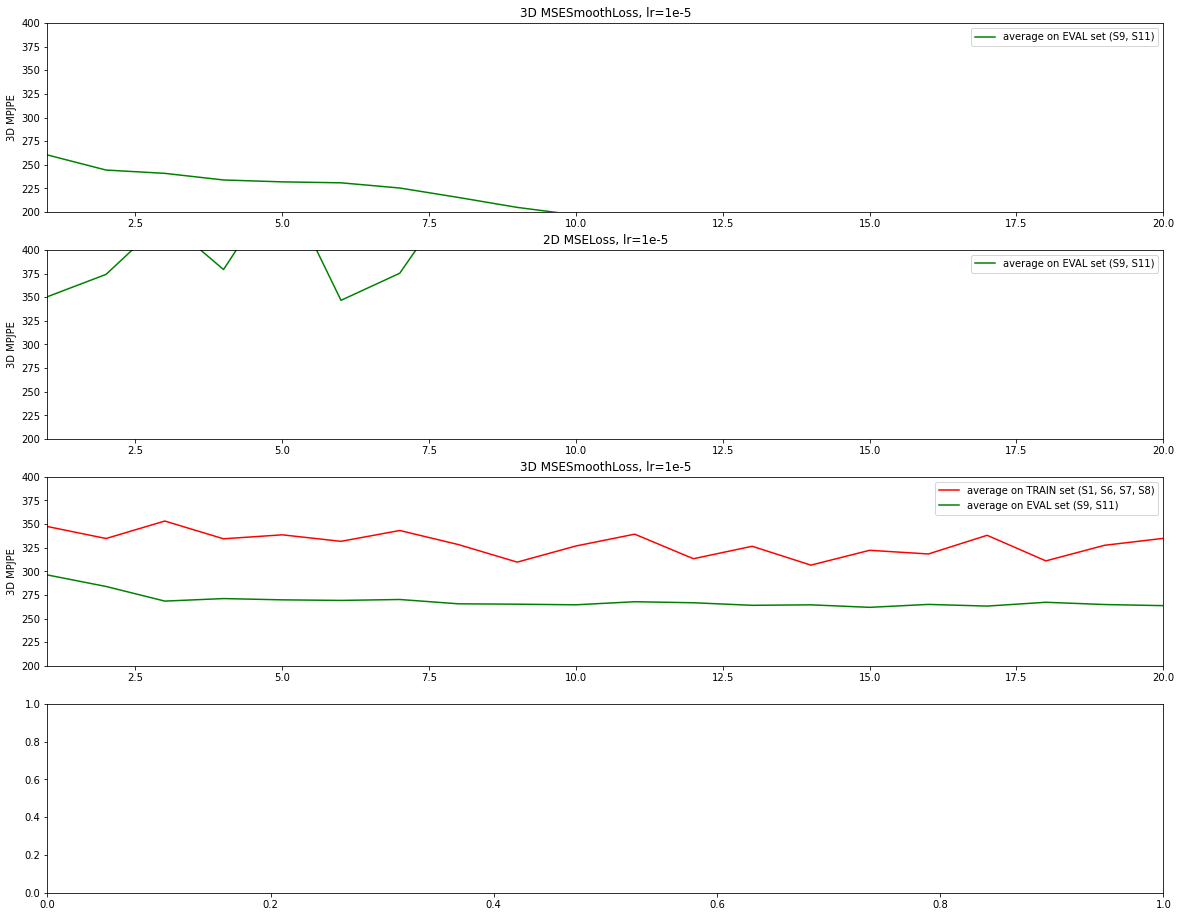

In [79]:
fig, ax = get_figa(4, 1)

for axis, metrics in zip(
        ax.ravel(),
        [ exp_03_31_19_00, exp_03_31_20_12, exp_04_08_12_07 ]
    ):
    plot_metrics(axis, metrics, iters_done)

    axis.set_ylim([200, 400])
    axis.set_xlim([1, 20])

    axis.set_ylabel('3D MPJPE')
    # axis.set_xlabel('epoch')
    
    axis.set_title(metrics['title'])

    axis.legend()

In [7]:
src_folder = Path('~/_tmp/tesi').expanduser()

kp_gt = np.load(src_folder / 'kp_gt.np.npy')
kp_pred = np.load(src_folder / 'kp_pred.np.npy')
images_batch = np.load(src_folder / 'wow.np.npy')

images_batch.shape

(8, 4, 3, 128, 128)

In [8]:
def normalize_transformation(feature_range):
    def _f(x):
        shape = x.shape
        
        m = x.min()
        M = x.max()
        
        x = (x - m) / (M - m) * (feature_range[1] - feature_range[0]) + feature_range[0]
        
        x = x.reshape(shape)  # original size
        return x

    return _f

In [9]:
canvas = images_batch[0, 0, 0].copy().reshape(128, 128)
canvas = normalize_transformation((0, 255))(canvas)
canvas = cv2.cvtColor(canvas, cv2.COLOR_GRAY2RGB)

# plt.imshow(canvas)

for pt in kp_gt:
    cv2.circle(
        canvas, tuple(pt.astype(int)),
        2, color=(0, 0, 255), thickness=3
    )

for pt in kp_pred:
    cv2.circle(
        canvas, tuple(pt.astype(int)),
        2, color=(0, 255, 0), thickness=3
    )
    
cv2.imwrite(str(src_folder / 'diocan.jpg'), canvas)

True